In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Download Tensorflow

In [8]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Download the neccessary data into the Colab Instance
We will split our dataset into three subsets: training set, validation set and testing set.

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub

BATCH_SIZE = 32
IMAGE_SIZE = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    return  image, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    data_dir='/content/dataset/',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    shuffle_files=True, 
    as_supervised=True,
)

# tf.data.experimental.cardinality(raw_train_dataset).numpy()
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print("Numbers of images: ", num_examples)
print("Numbers of classes: ", num_classes)

train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

Numbers of images:  23262
Numbers of classes:  2


## Transfer learning
We download the MobilenetV2 model and then take the feature extractor from the model. We define our last layer for cat vs dog classification and optimizer for our networks. Then, we train our networks within only 5 epochs.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

history = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 62s 88ms/step - loss: 0.0932 - accuracy: 0.9684 - val_loss: 0.0370 - val_accuracy: 0.9880
Epoch 2/5
582/582 [==============================] - 54s 85ms/step - loss: 0.0300 - accuracy: 0.9904 - val_loss: 0.0389 - val_accuracy: 0.9858
Epoch

## Plotting the training process
We plot the loss and accurracy of the training process with respect to the training set and the validation set

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


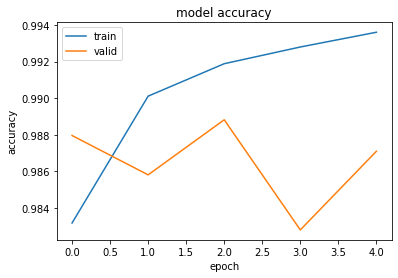

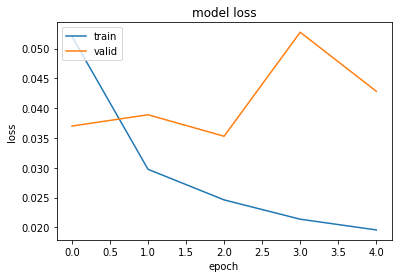

In [10]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Run your Model

Let's now take a look at actually running a prediction using the model. This code will test 100 images from the testing set

In [11]:
from tqdm import tqdm
import numpy as np

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    predictions.append(model.predict(img))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:06<00:00, 16.09it/s]

Out of 100 predictions I got 100 correct


## Save the model

In [16]:
CATS_VS_DOGS_SAVED_MODEL = "./content/exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)
# This will report back the file size in bytes

INFO:tensorflow:Assets written to: ./content/exp_saved_model.h5/assets


INFO:tensorflow:Assets written to: ./content/exp_saved_model.h5/assets


In [20]:
import os
# Get file size in bytes for a given model
print("Model in Mb:", os.path.getsize(CATS_VS_DOGS_SAVED_MODEL+'/saved_model.pb') / float(2**20))


Model in Mb: 1.888840675354004


##Exercice
What do you notice in term of:

* Model size 
* Training time
* Accuracy

compared to those of the last notebook.

What is the size of model in byte ?


## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)